In [2]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# pip install np_utils and then restart your terminal if you get error
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K


In [3]:
# Declare constants which will be used while plotting the data
FS_AXIS_LABEL=14
FS_TITLE=17
FS_TICKS=12
FIG_WIDTH=20
ROW_HEIGHT=3
TEXT_SPACING=4
RESIZE_DIM=48

For windows os the output will be  `'..\\input\\training-a\\*.png'`<br>
For linux os the output will be  `'../input/training-a/*.png'`

In [4]:
data_dir=os.path.join('..','/home/hasib/Hasib/Others/NumtaDB_with_aug')

# training images
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))

paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

# testing images
paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.jpg'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))

paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

# training labels
path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

#display a path
print(path_label_train_a)

/home/hasib/Hasib/Others/NumtaDB_with_aug/training-a.csv


# Reading Image Data

In [5]:
#get starting image path from all train sets
path_a=paths_train_a[0]
path_b=paths_train_b[0]
path_c=paths_train_c[0]
path_d=paths_train_d[0]
path_e=paths_train_e[0]

img=cv2.imread(path_a) # cv2 stores image in BGR format
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # transforming to RGB format

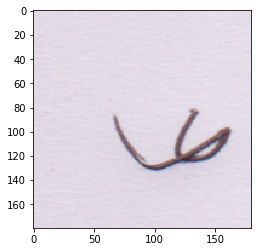

In [6]:
plt.imshow(img)
plt.show()

In [7]:
dfa = pd.read_csv(path_label_train_a) 
dfb = pd.read_csv(path_label_train_b)
dfc = pd.read_csv(path_label_train_c)
dfd = pd.read_csv(path_label_train_d)
dfe = pd.read_csv(path_label_train_e)

dfa=dfa.set_index('filename') 
dfb=dfb.set_index('filename') 
dfc=dfc.set_index('filename') 
dfd=dfd.set_index('filename') 
dfe=dfe.set_index('filename') 
dfa.head()
dfb.head()
dfc.head()
dfd.head()
dfe.head()


,original filename,districtid,institutionid,gender,age,datestamp,scanid,digit,database name original,database name
filename,,,,,,,,,,
e00000.png,02_0002_1_20_1016_1248_60.png,2,2,1,20,1016,1248,9,BanglaLekha-Isolated,training-e
e00001.png,02_0002_0_19_1016_1183_60.png,2,2,0,19,1016,1183,9,BanglaLekha-Isolated,training-e
e00002.png,01_0001_0_16_0916_0464_51.png,1,1,0,16,916,464,0,BanglaLekha-Isolated,training-e
e00003.png,02_0002_0_24_1016_1464_55.png,2,2,0,24,1016,1464,4,BanglaLekha-Isolated,training-e
e00004.png,02_0002_0_18_1016_1718_56.png,2,2,0,18,1016,1718,5,BanglaLekha-Isolated,training-e


In [8]:
def get_key(path):
    key=path.split(sep=os.sep)[-1]
    return key

def get_data_img(path, resize_dim=RESIZE_DIM):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    img_rz_rs=img_rz/255
    return img_rz_rs

def get_data(paths_img,path_label=None,resize_dim=None):
    X=[] 
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_COLOR) 
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) 
        X.append(img) 
      
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) 
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) 
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] 
        y=to_categorical(y_label,10) 
        return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10):
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()
    
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [19]:
#X_train_a=np.array([get_data_img(path_a) for path_a in paths_train_a])
X_train_a_48,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b_48,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c_48,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d_48,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e_48,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [17]:
#y_label_a=np.array([dfa.loc[get_key(path_a)]['digit'] for path_a in  paths_train_a])
#y_train_a=to_categorical(y_label_a, 10)

In [24]:
def get_model():
    model=Sequential()
    model.add(Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu',input_shape=(RESIZE_DIM, RESIZE_DIM, 3)))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    model.add(Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(units=64))
    model.add(Dense(units=10))
    
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model
model=get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 8)         608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
__________

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(
         rotation_range=30,
         width_shift_range=0.2,
         height_shift_range=0.2,
         shear_range=0.2,
         zoom_range=0.2,
         horizontal_flip=False,
         vertical_flip=False,
         fill_mode='nearest',
         )

count_a = 0
X_train_a_aug=[]
for train_batch, _ in datagen.flow(X_train_a_48, y_train_a, batch_size=1):
    X_train_a_aug.append(train_batch[0])
    count_a = count_a + 1
    if count_a ==len(paths_train_a):  #len(paths_train_a) = 19720
        break
X_train_a_aug=np.array(X_train_a_aug)
print(X_train_a_aug.shape)

(19702, 48, 48, 3)


In [20]:
count_b = 0
X_train_b_aug=[]
for train_batch, _ in datagen.flow(X_train_b_48, y_train_b, batch_size=1):
    X_train_b_aug.append(train_batch[0])
    count_b = count_b + 1
    if count_b ==len(paths_train_b):  #len(paths_train_a) = 19720
        break
X_train_b_aug=np.array(X_train_b_aug)

count_c = 0
X_train_c_aug=[]
for train_batch, _ in datagen.flow(X_train_c_48, y_train_c, batch_size=1):
    X_train_c_aug.append(train_batch[0])
    count_c = count_c + 1
    if count_c ==len(paths_train_c):  #len(paths_train_a) = 19720
        break
X_train_c_aug=np.array(X_train_c_aug)

count_d = 0
X_train_d_aug=[]
for train_batch, _ in datagen.flow(X_train_d_48, y_train_d, batch_size=1):
    X_train_d_aug.append(train_batch[0])
    count_d = count_d + 1
    if count_d ==len(paths_train_d):  #len(paths_train_a) = 19720
        break
X_train_d_aug=np.array(X_train_d_aug)

count_e = 0
X_train_e_aug=[]
for train_batch, _ in datagen.flow(X_train_e_48, y_train_e, batch_size=1):
    X_train_e_aug.append(train_batch[0])
    count_e = count_e + 1
    if count_e ==len(paths_train_e):  #len(paths_train_a) = 19720
        break
X_train_e_aug=np.array(X_train_e_aug)

print(X_train_b_aug.shape)
print(X_train_c_aug.shape)
print(X_train_d_aug.shape)
print(X_train_e_aug.shape)

(359, 48, 48, 3)
(24298, 48, 48, 3)
(10908, 48, 48, 3)
(16778, 48, 48, 3)


In [21]:
X_train_all_aug=np.concatenate((X_train_a_48,X_train_b_48,X_train_c_48, X_train_d_48,X_train_e_48, X_train_a_aug,X_train_b_aug,X_train_c_aug,X_train_d_aug,X_train_e_aug),axis=0)
y_train_all_aug=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e,y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all_aug.shape, y_train_all_aug.shape

((144090, 48, 48, 3), (144090, 10))

In [22]:
#imshow_group(X_train_aug)

indices=list(range(len(X_train_all_aug)))
np.random.seed(42)
np.random.shuffle(indices)
ind=int(len(indices)*0.80) # model will be trained with 80% of the training data

# training data
X_train=X_train_all_aug[indices[:ind]] 
y_train=y_train_all_aug[indices[:ind]] 

# validation data
X_val=X_train_all_aug[indices[-(len(indices)-ind):]] 
y_val=y_train_all_aug[indices[-(len(indices)-ind):]]

print(X_train_all_aug.shape)
print(y_train_all_aug.shape)
print("   ")
print(X_train.shape)
print(y_train.shape)
print("   ")
print(X_val.shape)
print(y_val.shape)

MemoryError: 

In [102]:
"""
def data_aug(X_train,X_test,y_train,y_test,train_batch_size,test_batch_size):
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #rescale=1.0/255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')
    test_datagen = ImageDataGenerator()#rescale=1.0/255)
    train_batch = train_datagen.flow(X_train,y_train,batch_size=train_batch_size)
    test_batch = test_datagen.flow(X_test,y_test,batch_size=test_batch_size)
    return (train_batch,test_batch)
"""

## Training on augmented data

In [33]:
path_model='model_augmented.h5' # save model at this location after each epoch

In [25]:
import gc
gc.collect()
K.clear_session()
model = get_model()

# Call augmentation function
batch_size = 64
#train_batch, val_batch = data_aug(X_train,X_val,y_train,y_val, batch_size, batch_size)

# Fit generator for Data Augmentation - UNCOMMENT THIS FOR DATA AUGMENTATION
batch_size = 64
epochs = 2


h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=2, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )
"""
history = model.fit_generator(train_batch, 
                              validation_data=val_batch, 
                              epochs=epochs, 
                              validation_steps= X_val.shape[0] // batch_size,
                              steps_per_epoch= X_train.shape[0] // batch_size, 
                              verbose=2
                             )
"""

NameError: name 'X_train' is not defined